In [42]:
import pandas as pd
import pandas_profiling
from gc import collect
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.preprocessing import normalize
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
%matplotlib inline

In [3]:
df = pd.read_excel('bases_hk1_hk2.xlsx')

In [4]:
pandas_profiling.ProfileReport(df)

Number of variables,26
Number of observations,768
Total Missing (%),0.0%
Total size in memory,156.1 KiB
Average record size in memory,208.1 B
Numeric,12
Categorical,13
Date,0
Text (Unique),1
Rejected,0
Distinct count,2


In [5]:
dtypes = ['category', 'bool', 'object']
df_categorical = df.loc[:, [col for col in df.columns]].select_dtypes(include=dtypes)
df_categorical.head()
df_categorical.shape
list(df_categorical)

,cod_ide,Cargo,cero_cuotas,Amonestacion,nAmonestacion_suspension,herencia,nProbMoraNoHeredada,nProbMoraHeredada,Clasificacion_Asesor_Urb_Rur,Genero,EstadoCivil,Estado_Civil_Sexo,nProductividad_dic,ingresoef
0,C00000001,ASESOR COMERCIAL FUNCIONARIO,si,no,no,si,bueno,malo,U,Masculino,Soltero,M_Soltero,bueno,NO
1,C00000002,ASESOR COMERCIAL MASTER,si,no,no,si,malo,malo,U,Femenino,Otros,otros,bueno,NO
2,C00000003,ASESOR COMERCIAL MASTER,si,no,no,si,malo,bueno,U,Femenino,Casado,Casado,bueno,NO
3,C00000004,ASESOR COMERCIAL FUNCIONARIO,si,no,no,si,bueno,malo,U,Femenino,Soltero,F_Soltero,bueno,NO
4,C00000005,ASESOR COMERCIAL FUNCIONARIO,no,no,no,si,malo,bueno,U,Femenino,Soltero,F_Soltero,bueno,NO


(768, 14)

['cod_ide',
 'Cargo',
 'cero_cuotas',
 'Amonestacion',
 'nAmonestacion_suspension',
 'herencia',
 'nProbMoraNoHeredada',
 'nProbMoraHeredada',
 'Clasificacion_Asesor_Urb_Rur',
 'Genero',
 'EstadoCivil',
 'Estado_Civil_Sexo',
 'nProductividad_dic',
 'ingresoef']

In [6]:
df = pd.get_dummies(df, columns=['Cargo', 'Genero', 'EstadoCivil', 'Clasificacion_Asesor_Urb_Rur'], prefix='D_')

for feature in ['nProbMoraNoHeredada', 'nProbMoraHeredada', 'nProductividad_dic']:
    df.loc[:, feature] = df.loc[:, feature].map({ 'bueno': 1, 'malo': 0 })
    
for feature in ['cero_cuotas', 'Amonestacion', 'nAmonestacion_suspension', 'herencia']:
    df.loc[:, feature] = df.loc[:, feature].map({ 'si': 1, 'no': 0 })
    
df.loc[:, 'ingresoef'] = df.loc[:, 'ingresoef'].map({ 'SI': 1, 'NO': 0 })

df_categorical = df.loc[:, [col for col in list(df) if col in list(df_categorical) or col.startswith('D_')]]

for feature in list(df_categorical):
    df[feature].value_counts()

C00000693    1
C00000720    1
C00000359    1
C00000602    1
C00000322    1
C00000009    1
C00000545    1
C00000121    1
C00000172    1
C00000430    1
C00000655    1
C00000016    1
C00000457    1
C00000390    1
C00000536    1
C00000109    1
C00000473    1
C00000415    1
C00000505    1
C00000538    1
C00000589    1
C00000619    1
C00000206    1
C00000437    1
C00000662    1
C00000577    1
C00000060    1
C00000325    1
C00000163    1
C00000351    1
            ..
C00000759    1
C00000211    1
C00000195    1
C00000201    1
C00000714    1
C00000481    1
C00000011    1
C00000239    1
C00000729    1
C00000374    1
C00000283    1
C00000656    1
C00000175    1
C00000158    1
C00000220    1
C00000387    1
C00000417    1
C00000161    1
C00000471    1
C00000607    1
C00000285    1
C00000004    1
C00000193    1
C00000747    1
C00000487    1
C00000460    1
C00000575    1
C00000733    1
C00000068    1
C00000459    1
Name: cod_ide, Length: 768, dtype: int64

1    514
0    254
Name: cero_cuotas, dtype: int64

0    721
1     47
Name: Amonestacion, dtype: int64

0    574
1    194
Name: nAmonestacion_suspension, dtype: int64

1    723
0     45
Name: herencia, dtype: int64

0    417
1    351
Name: nProbMoraNoHeredada, dtype: int64

1    402
0    366
Name: nProbMoraHeredada, dtype: int64

M_Soltero    350
F_Soltero    179
Casado       147
otros         92
Name: Estado_Civil_Sexo, dtype: int64

1    731
0     37
Name: nProductividad_dic, dtype: int64

0    584
1    184
Name: ingresoef, dtype: int64

0    707
1     61
Name: D__ASESOR COMERCIAL FUNCIONARIO, dtype: int64

0    611
1    157
Name: D__ASESOR COMERCIAL JUNIOR 1, dtype: int64

0    528
1    240
Name: D__ASESOR COMERCIAL JUNIOR 2, dtype: int64

0    637
1    131
Name: D__ASESOR COMERCIAL MASTER, dtype: int64

0    589
1    179
Name: D__ASESOR COMERCIAL SENIOR, dtype: int64

0    530
1    238
Name: D__Femenino, dtype: int64

1    530
0    238
Name: D__Masculino, dtype: int64

0    621
1    147
Name: D__Casado, dtype: int64

0    676
1     92
Name: D__Otros, dtype: int64

1    529
0    239
Name: D__Soltero, dtype: int64

0    607
1    161
Name: D__R, dtype: int64

1    607
0    161
Name: D__U, dtype: int64

In [7]:
dtypes = ['number']
df_numeric = df.loc[:, [col for col in df.columns if col not in df_categorical.columns]].select_dtypes(include=dtypes)
df_numeric.head()
df_numeric.shape
list(df_numeric)

,Y,nEntidades_competencia,nDesem_ult_semana,nPorcentaje_cero_cuotas_ope,nPorcentaje_sal_cero_cuo,nvarsaldocapital,nporcentaje_Herencia,nOperaciones,nRatio_crec_deuda,Edad,nProductividad,antiguedad
0,1,1,0.256354,0.000000,0.000000,0.013561,0.380552,20,0.880677,36,0.823077,116
1,1,0,0.406922,0.001969,0.000141,0.042866,0.444054,24,2.061512,46,0.750000,16
2,0,5,0.321911,0.000000,0.000000,-0.005801,0.020612,22,0.668892,58,0.827303,140
3,0,3,0.294114,0.008791,0.015452,0.018111,0.300313,26,0.722767,34,1.100000,10
4,1,2,0.315331,0.000000,0.000000,0.004865,0.151475,26,0.000000,36,0.906250,119


(768, 12)

['Y',
 'nEntidades_competencia',
 'nDesem_ult_semana',
 'nPorcentaje_cero_cuotas_ope',
 'nPorcentaje_sal_cero_cuo',
 'nvarsaldocapital',
 'nporcentaje_Herencia',
 'nOperaciones',
 'nRatio_crec_deuda',
 'Edad',
 'nProductividad',
 'antiguedad']

In [8]:
df_discrete = df.loc[:, [col for col in df_numeric.columns if (df[col].dropna() - df[col].dropna().astype(int) == 0).all()]]
df_discrete.head()
df_discrete.shape
list(df_discrete)

,Y,nEntidades_competencia,nOperaciones,Edad,antiguedad
0,1,1,20,36,116
1,1,0,24,46,16
2,0,5,22,58,140
3,0,3,26,34,10
4,1,2,26,36,119


(768, 5)

['Y', 'nEntidades_competencia', 'nOperaciones', 'Edad', 'antiguedad']

In [9]:
df_continuous = df.loc[:, [col for col in df_numeric.columns if col not in df_discrete]]
df_continuous.head()
df_continuous.shape
list(df_continuous)

,nDesem_ult_semana,nPorcentaje_cero_cuotas_ope,nPorcentaje_sal_cero_cuo,nvarsaldocapital,nporcentaje_Herencia,nRatio_crec_deuda,nProductividad
0,0.256354,0.000000,0.000000,0.013561,0.380552,0.880677,0.823077
1,0.406922,0.001969,0.000141,0.042866,0.444054,2.061512,0.750000
2,0.321911,0.000000,0.000000,-0.005801,0.020612,0.668892,0.827303
3,0.294114,0.008791,0.015452,0.018111,0.300313,0.722767,1.100000
4,0.315331,0.000000,0.000000,0.004865,0.151475,0.000000,0.906250


(768, 7)

['nDesem_ult_semana',
 'nPorcentaje_cero_cuotas_ope',
 'nPorcentaje_sal_cero_cuo',
 'nvarsaldocapital',
 'nporcentaje_Herencia',
 'nRatio_crec_deuda',
 'nProductividad']

## Corr

In [10]:
def make_correlation_graphic(df):
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 15))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

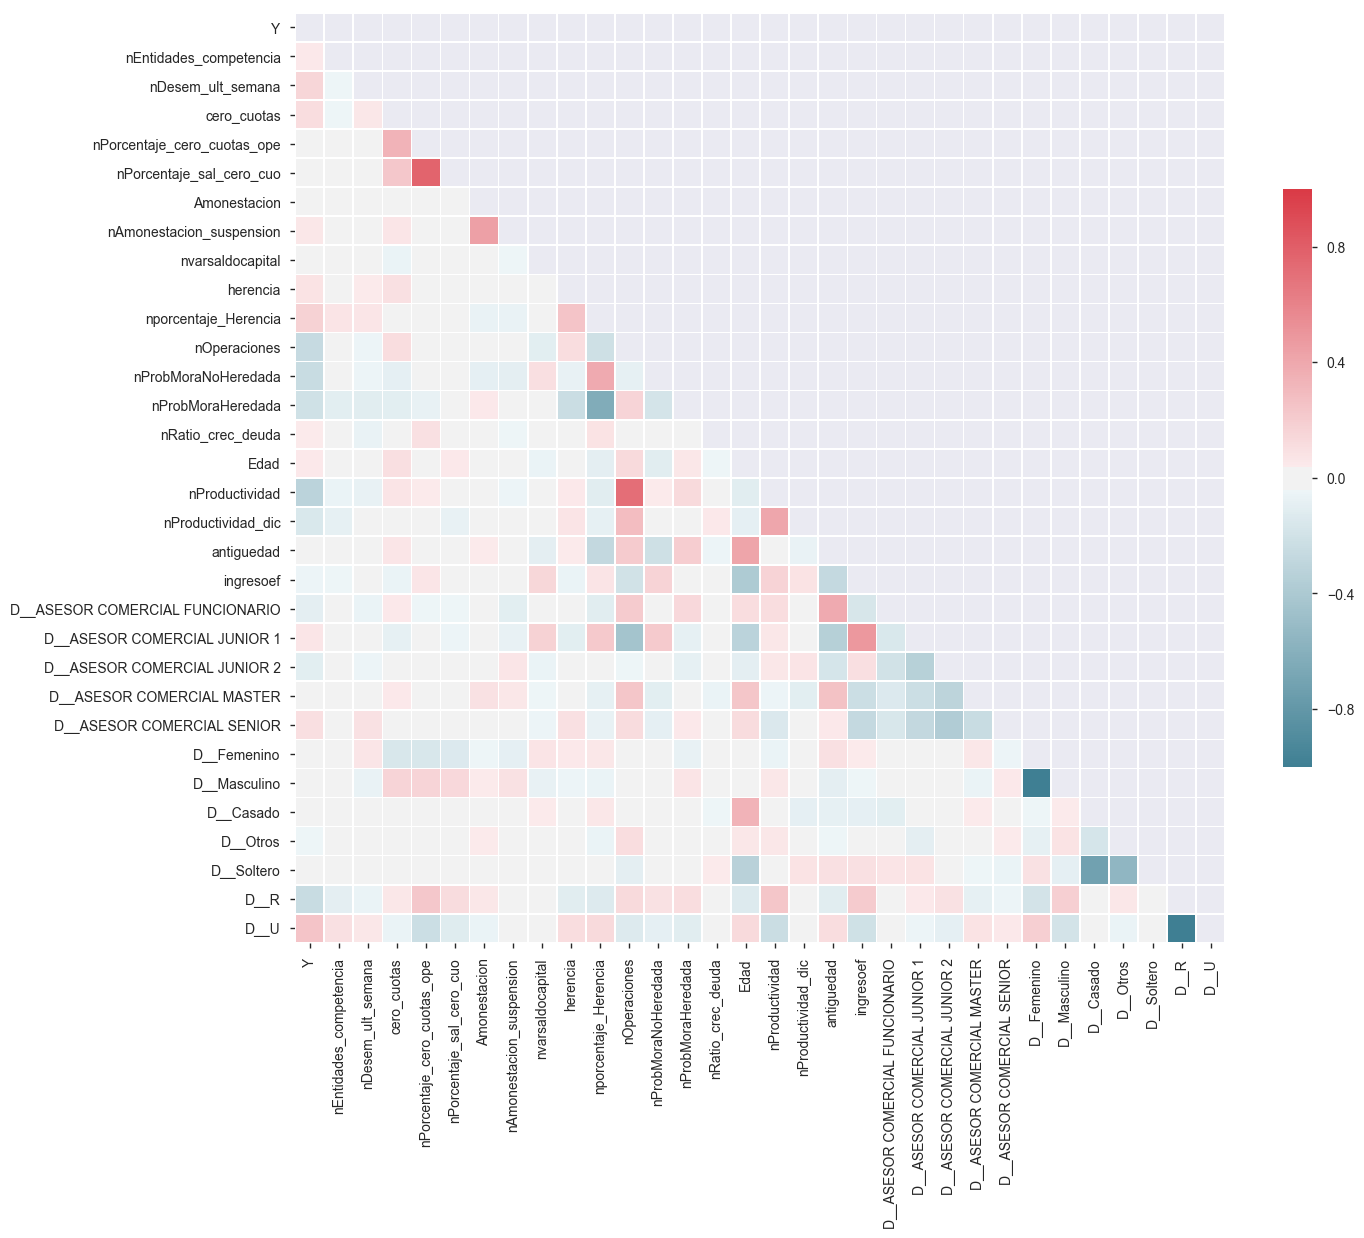

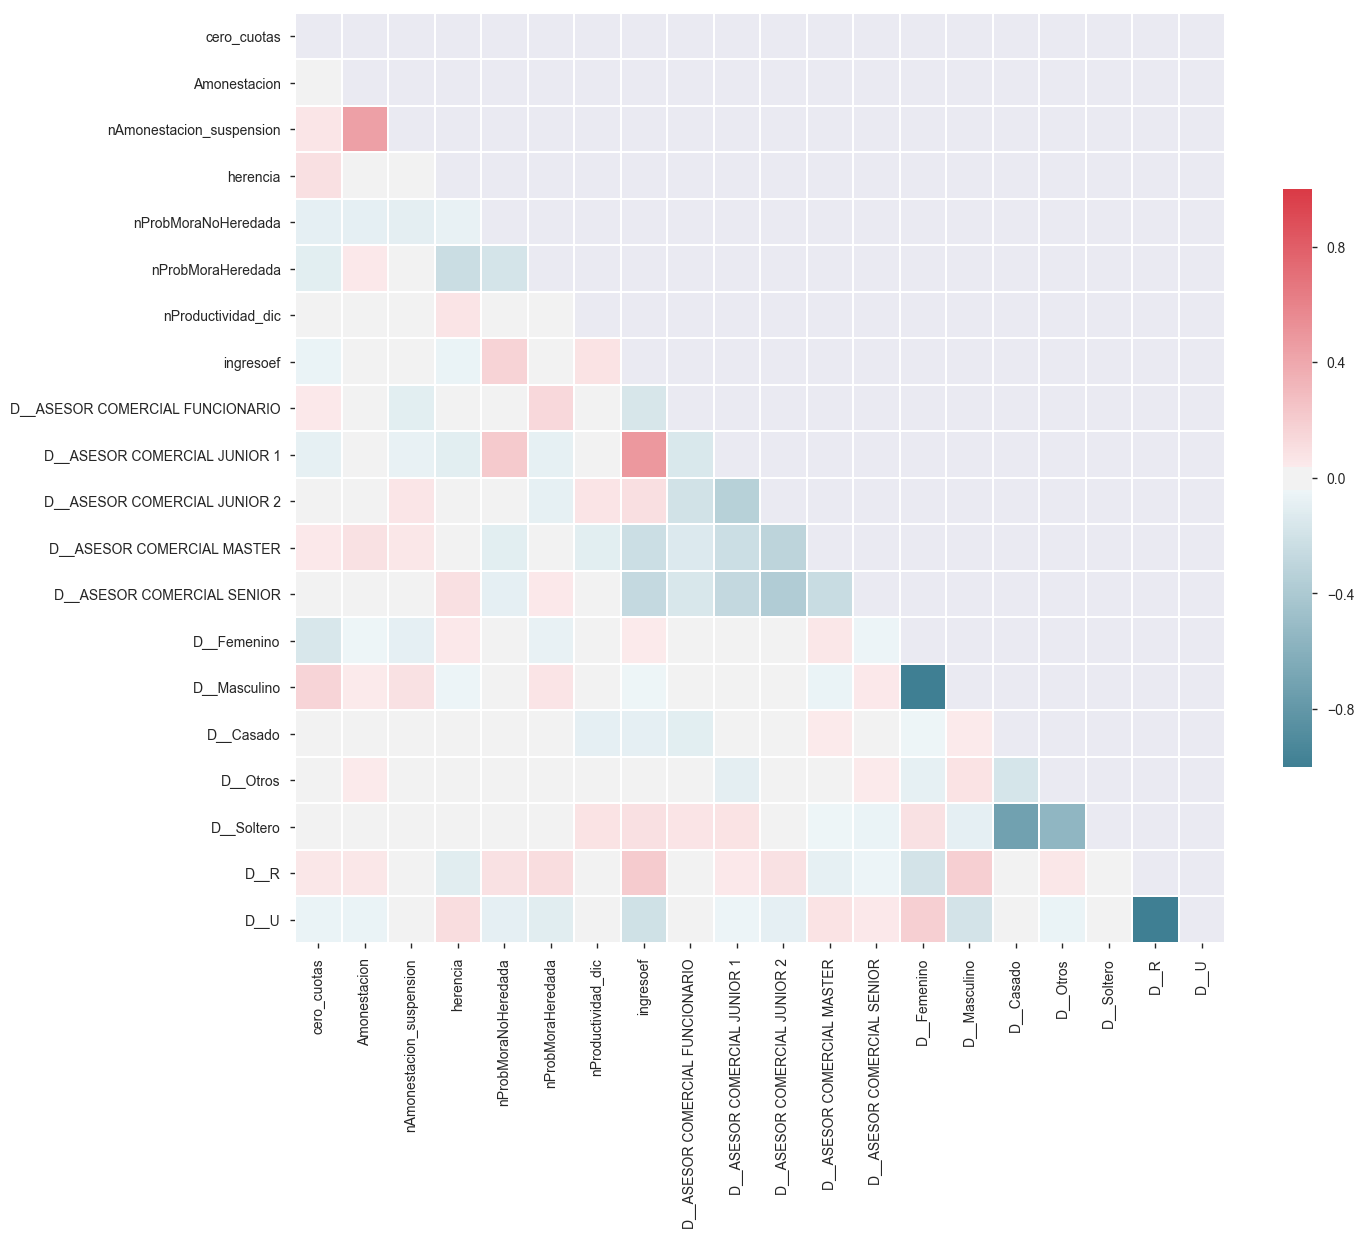

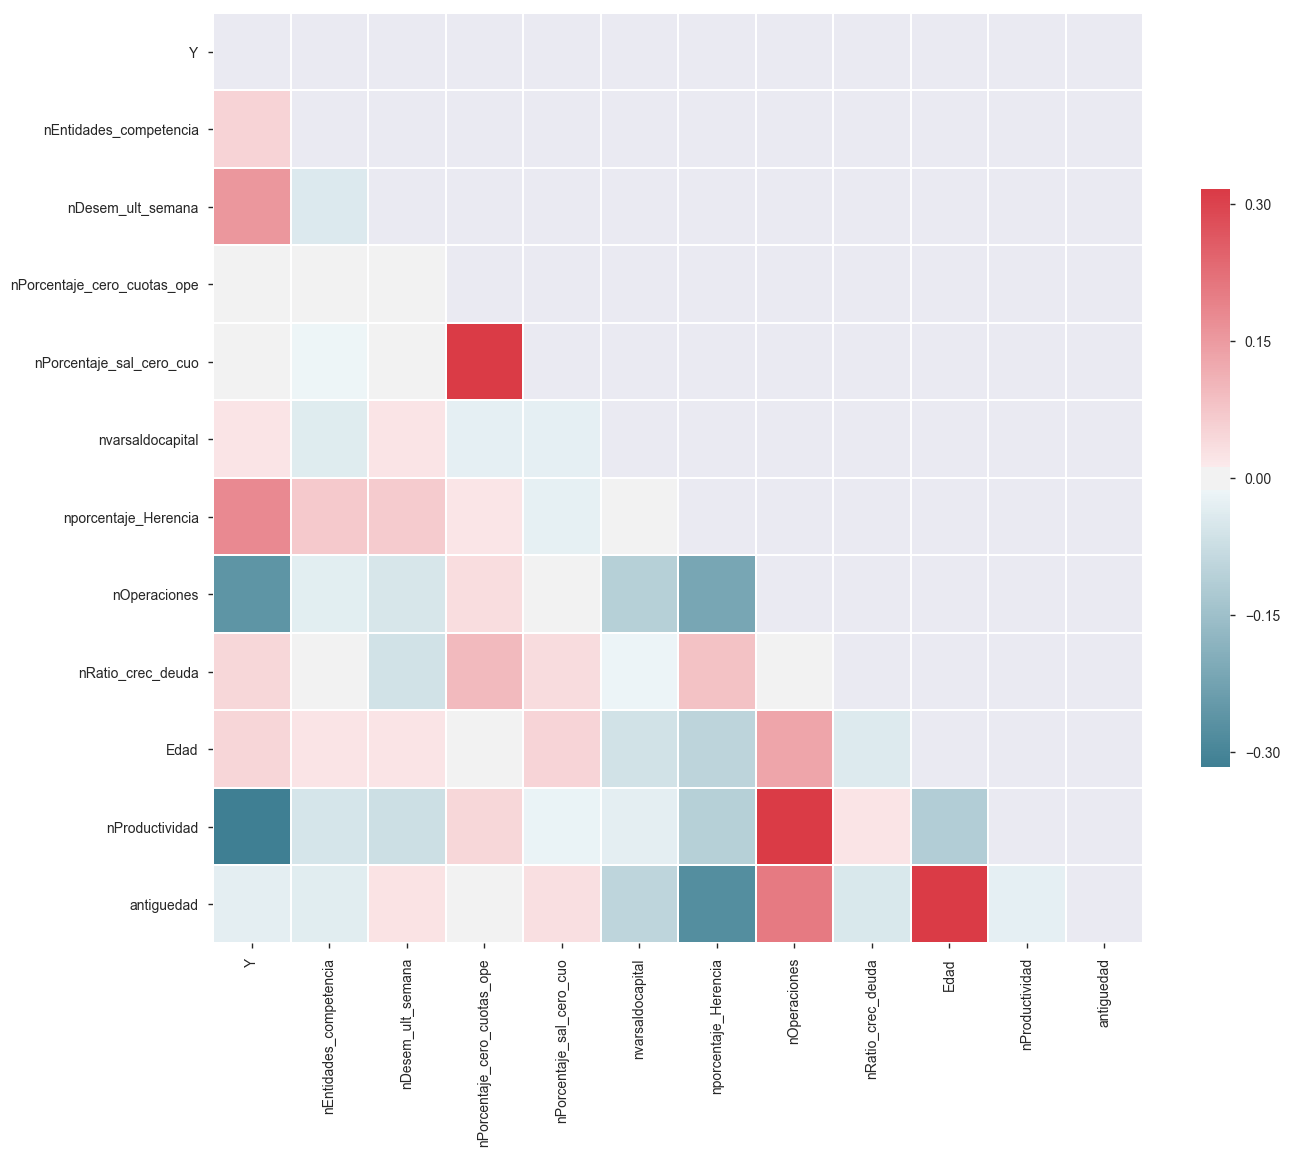

In [11]:
make_correlation_graphic(df)
make_correlation_graphic(df_categorical)
make_correlation_graphic(df_numeric)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


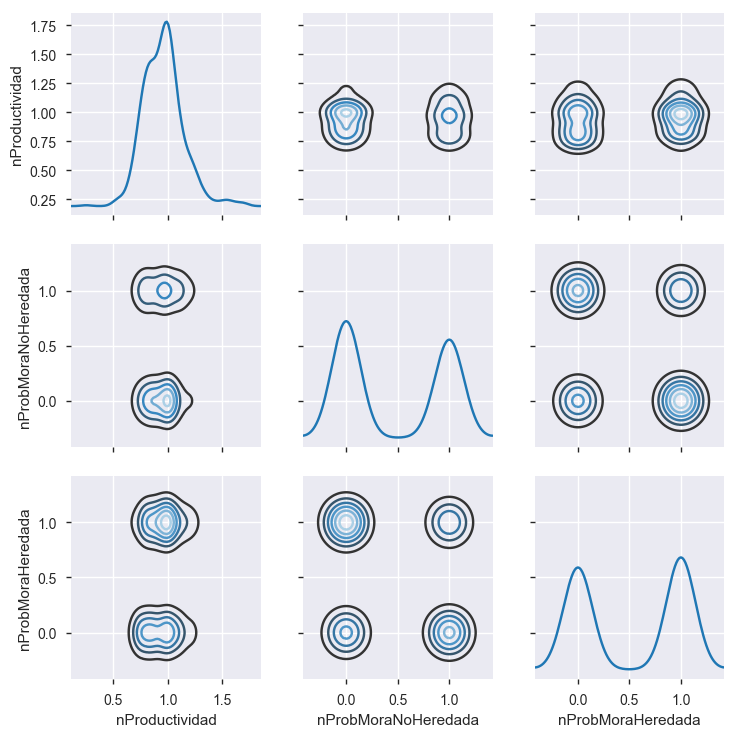

In [12]:
g = sns.PairGrid(df[['nProductividad', 'nProbMoraNoHeredada', 'nProbMoraHeredada']])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6)

In [13]:
df['PM'] = df['nProbMoraHeredada'] + df['nProbMoraNoHeredada']

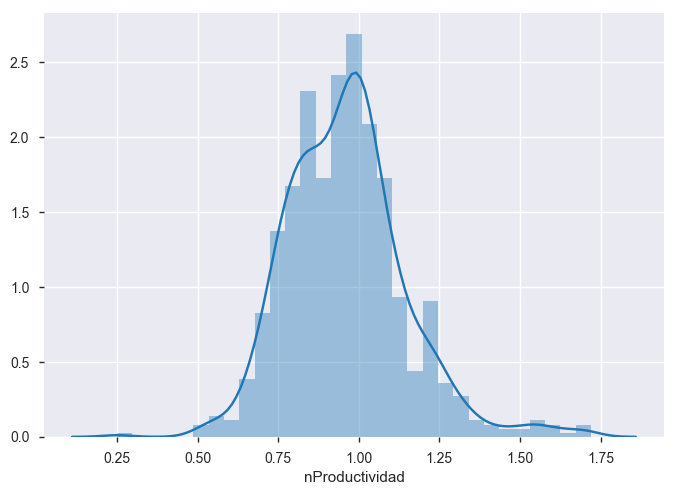

In [14]:
sns.distplot(df['nProductividad'])

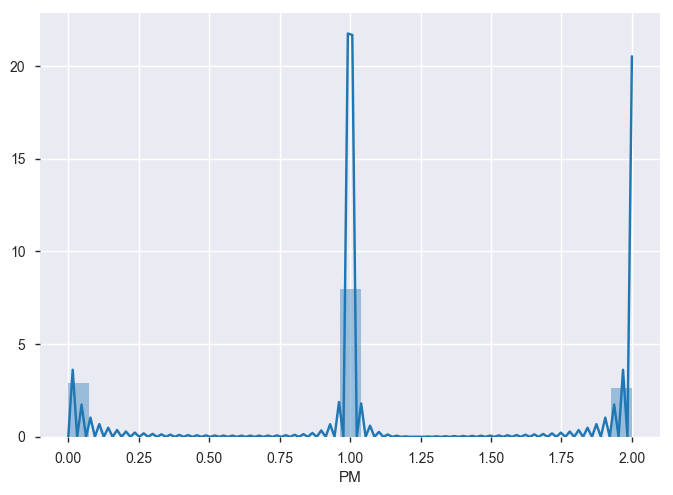

In [15]:
sns.distplot(df['PM'])

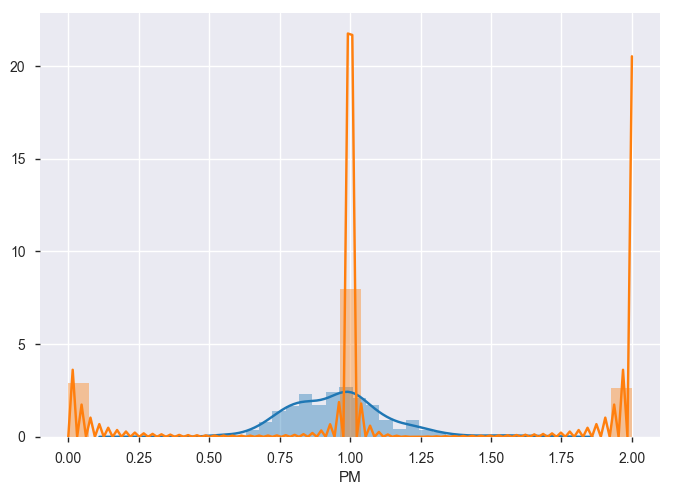

In [16]:
for feature in ['nProductividad', 'PM']:
    sns.distplot(df[feature])

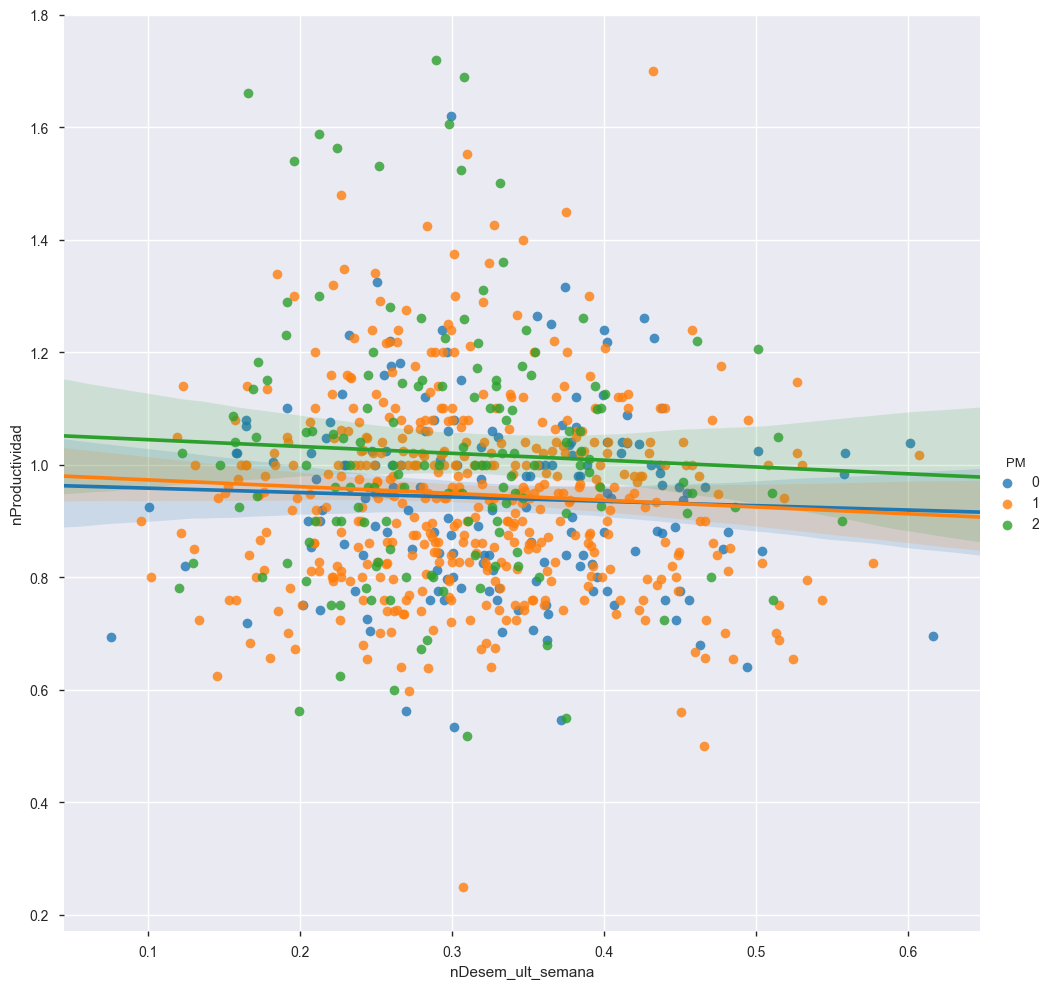

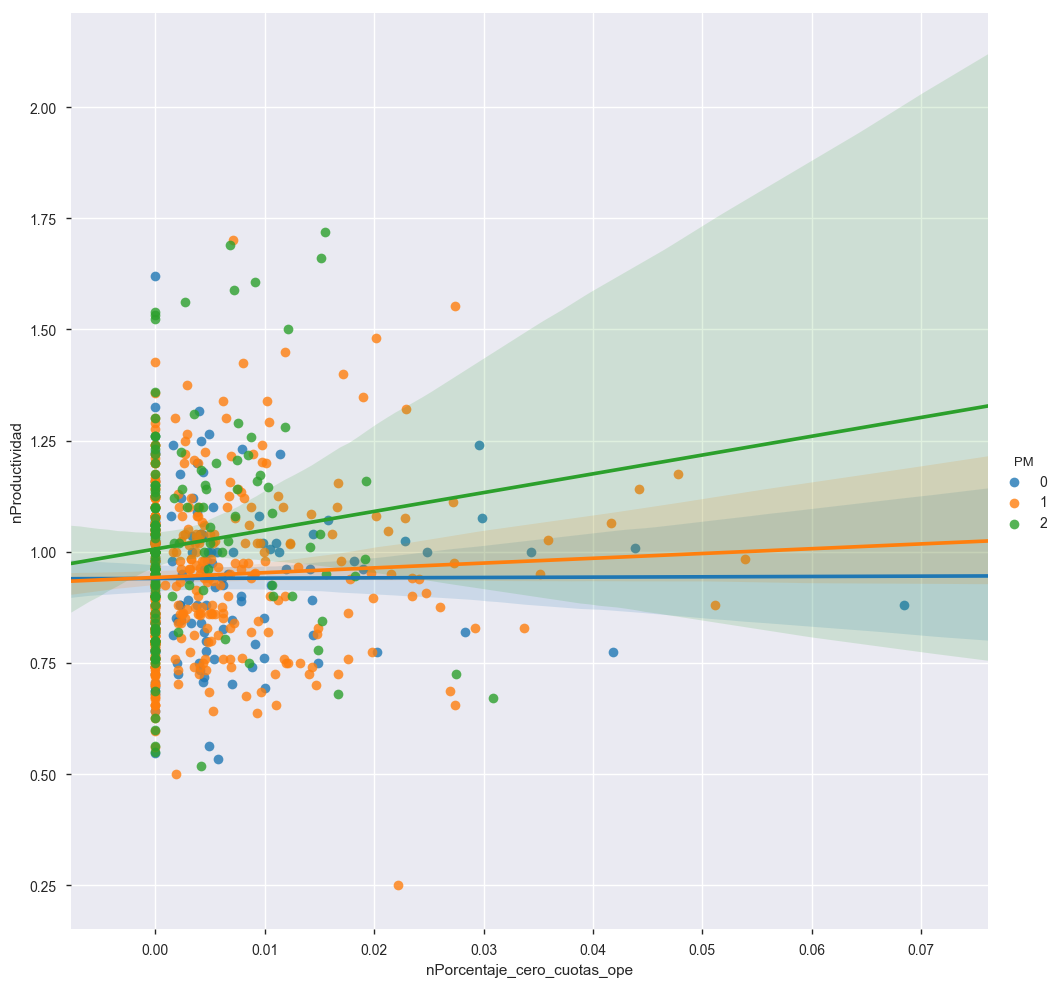

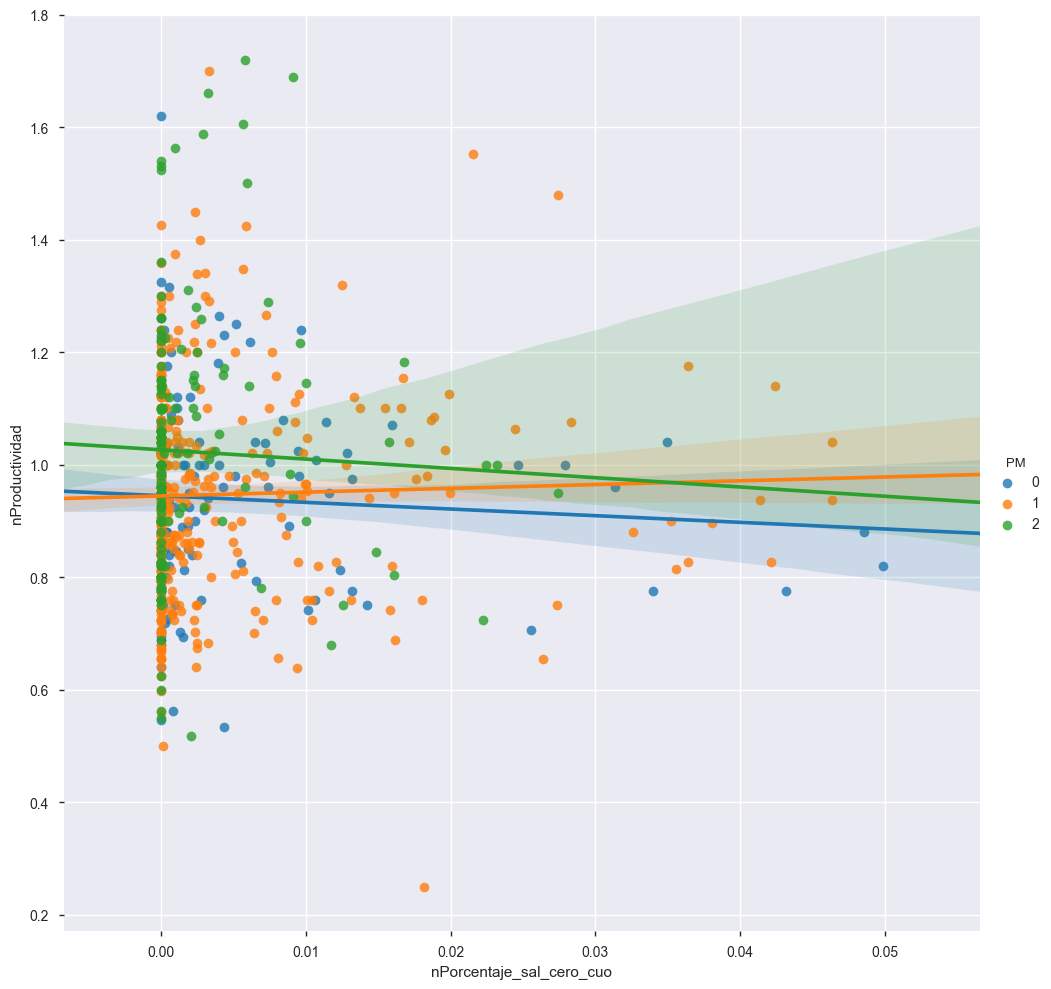

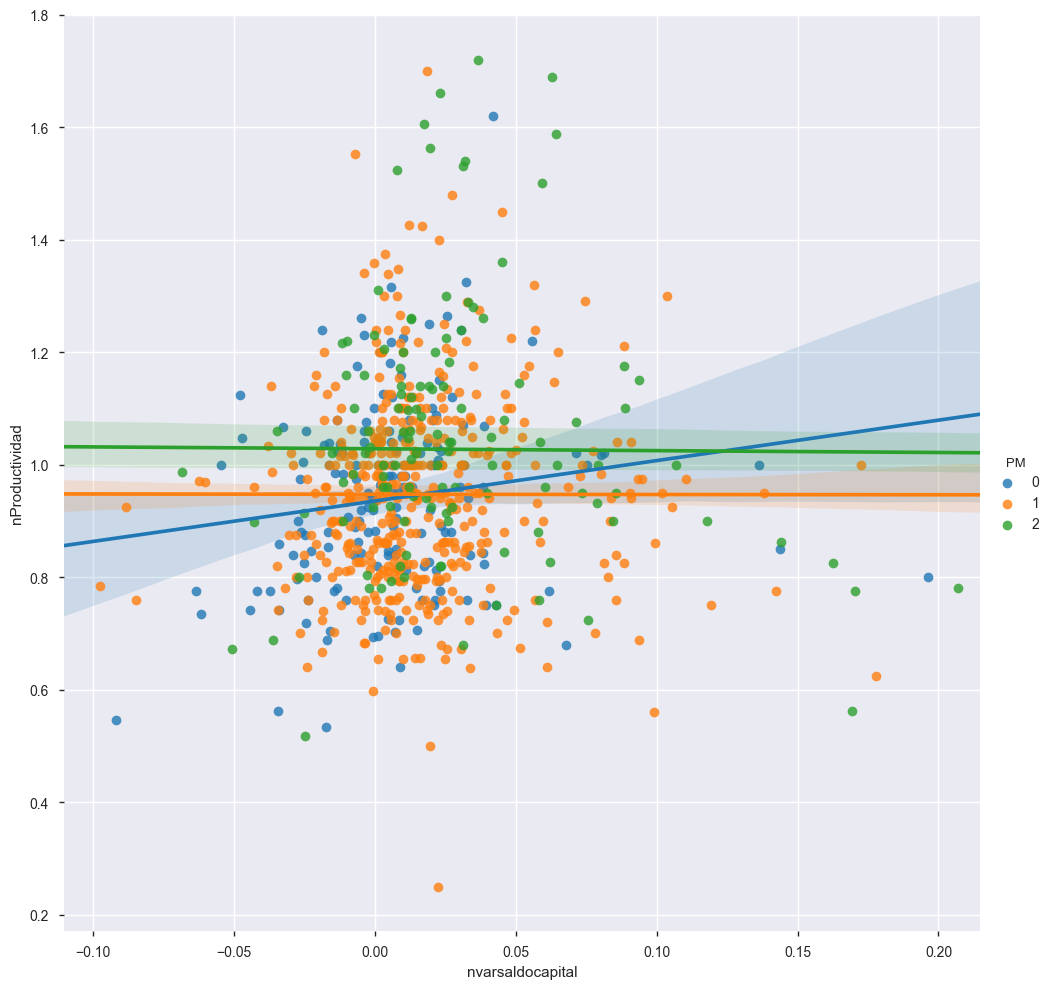

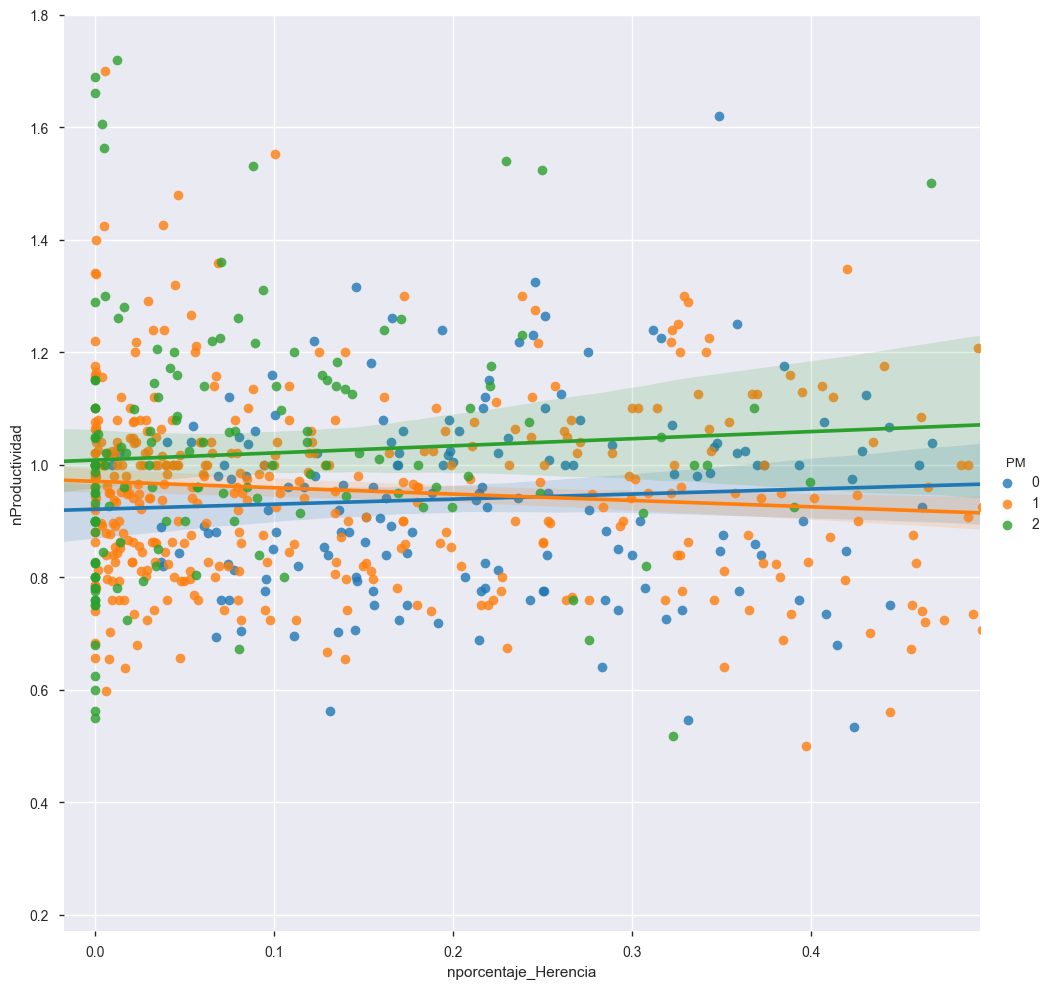

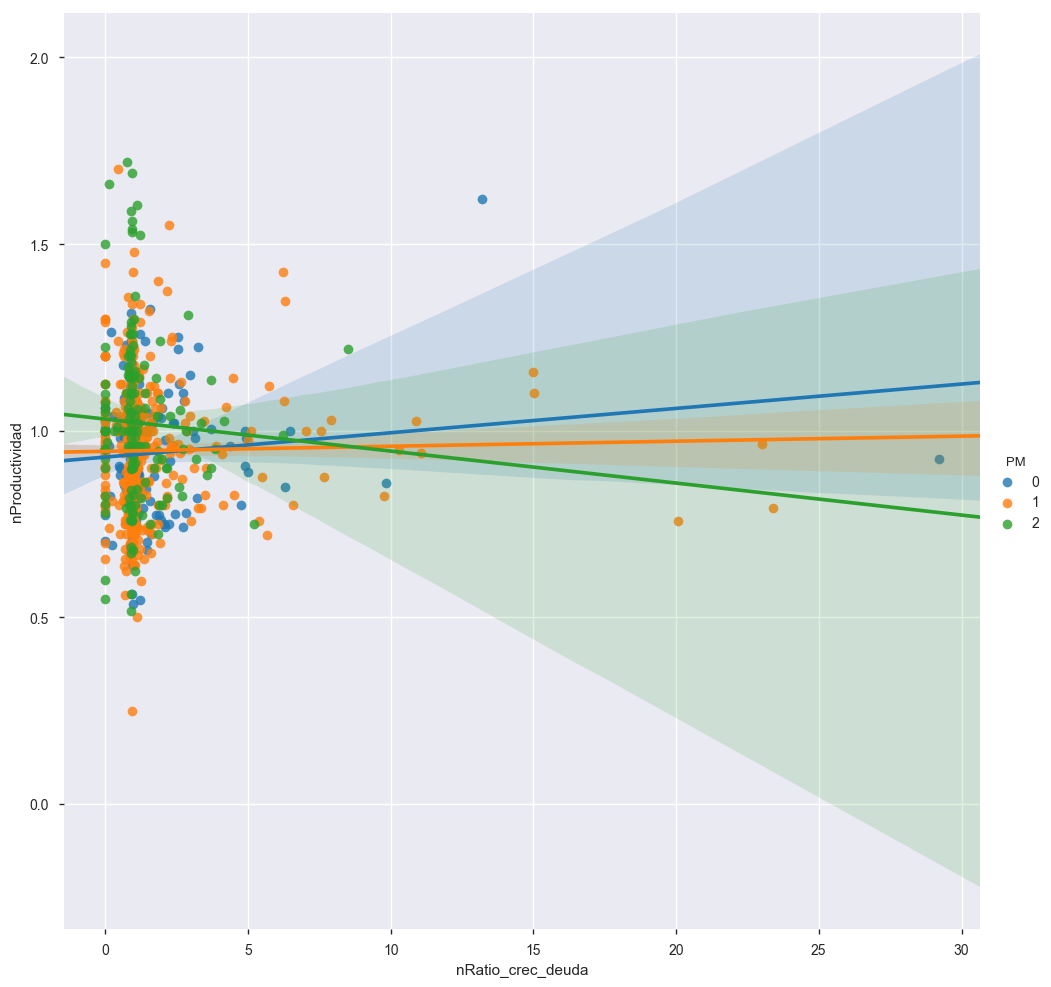

In [17]:
pair_vars = list(df_continuous)
pair_vars.remove('nProductividad')
for feature in pair_vars:
    sns.pairplot(df, x_vars=[feature], y_vars=["nProductividad"], hue="PM", size=10, aspect=1, kind="reg");

# Creating target

In [19]:
df['PM'].value_counts()

1    455
0    164
2    149
Name: PM, dtype: int64

In [20]:
def convert_score(el):
    return 1/(el + 1)

In [21]:
df.loc[:, 'PM'] = df.loc[:, 'PM'].apply(convert_score)

In [22]:
df['PM'].value_counts()

0.500000    455
1.000000    164
0.333333    149
Name: PM, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


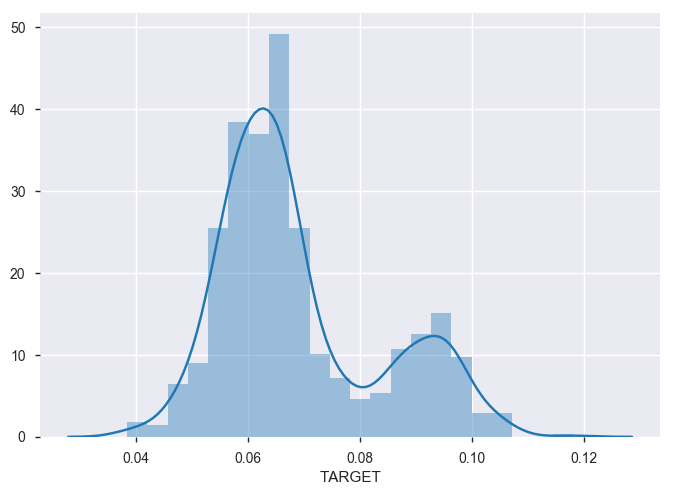

In [23]:
df['N_nProductividad'] = normalize(df['nProductividad'])[0]
df['N_PM'] = normalize(df['PM'])[0]
df['TARGET'] = df['N_nProductividad'] + df['N_PM']
sns.distplot(df['TARGET'])

In [24]:
df = df.drop(['PM', 'N_nProductividad', 'N_PM', 'nProductividad', 'nProbMoraHeredada', 'nProbMoraNoHeredada'], axis=1)
list(df)

['cod_ide',
 'Y',
 'nEntidades_competencia',
 'nDesem_ult_semana',
 'cero_cuotas',
 'nPorcentaje_cero_cuotas_ope',
 'nPorcentaje_sal_cero_cuo',
 'Amonestacion',
 'nAmonestacion_suspension',
 'nvarsaldocapital',
 'herencia',
 'nporcentaje_Herencia',
 'nOperaciones',
 'nRatio_crec_deuda',
 'Edad',
 'Estado_Civil_Sexo',
 'nProductividad_dic',
 'antiguedad',
 'ingresoef',
 'D__ASESOR COMERCIAL FUNCIONARIO',
 'D__ASESOR COMERCIAL JUNIOR 1',
 'D__ASESOR COMERCIAL JUNIOR 2',
 'D__ASESOR COMERCIAL MASTER',
 'D__ASESOR COMERCIAL SENIOR',
 'D__Femenino',
 'D__Masculino',
 'D__Casado',
 'D__Otros',
 'D__Soltero',
 'D__R',
 'D__U',
 'TARGET']

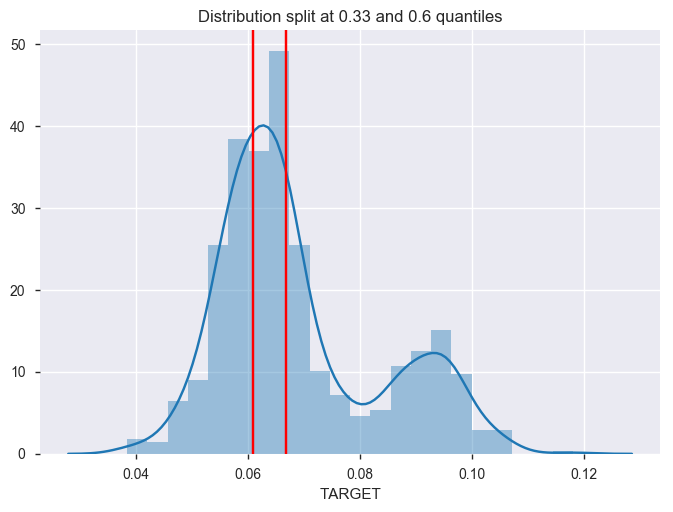

In [25]:
margin1 = 0.33
margin2 = 0.60

sns.distplot(df['TARGET'])
sns.plt.title('Distribution split at {} and {} quantiles'.format(margin1, margin2))
sns.plt.axvline(df['TARGET'].quantile(margin1), color='r')
sns.plt.axvline(df['TARGET'].quantile(margin2), color='r')

plt.show()

In [26]:
df[['cod_ide', 'TARGET']].head()

,cod_ide,TARGET
0,C00000001,0.059532
1,C00000002,0.085980
2,C00000003,0.059688
3,C00000004,0.069756
4,C00000005,0.062603


In [27]:
categories = ['bad', 'normal', 'good']
cuts = [min(df['TARGET']), df['TARGET'].quantile(margin1), df['TARGET'].quantile(margin2), max(df['TARGET'])]
df['TARGET'] = pd.cut(df['TARGET'], cuts, labels=categories, include_lowest=True)

In [28]:
df[['cod_ide', 'TARGET']].head()

,cod_ide,TARGET
0,C00000001,bad
1,C00000002,good
2,C00000003,bad
3,C00000004,good
4,C00000005,normal


In [29]:
df.loc[:, 'TARGET'] = df.loc[:, 'TARGET'].map({
    'bad': 0,
    'normal': 1,
    'good': 2
})
df['TARGET'].value_counts()

2    307
0    258
1    203
Name: TARGET, dtype: int64

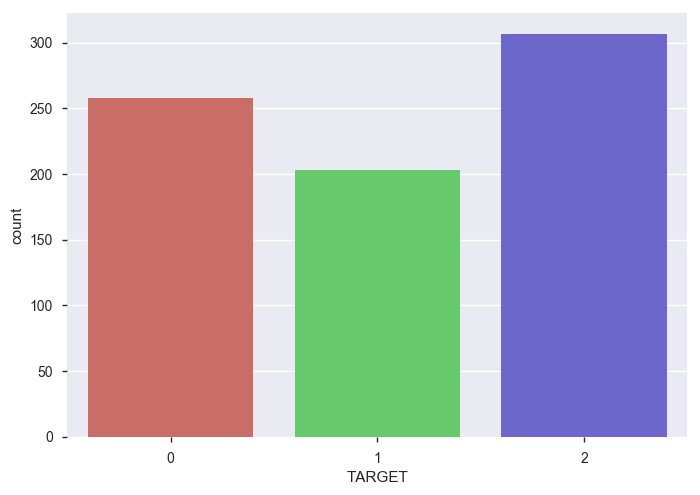

In [30]:
sns.countplot(x="TARGET", data=df, palette='hls')

In [32]:
df = df.drop(['cod_ide', 'Y', 'Estado_Civil_Sexo'], axis=1)

In [33]:
y = df['TARGET']
X = df.drop('TARGET', axis=1)

eval_size = 0.1
kf = StratifiedKFold(df['TARGET'], round(1./eval_size))
train_ix, valid_ix = next(iter(kf))

In [34]:
X_train, y_train = X.iloc[train_ix], y.iloc[train_ix]
X_valid, y_valid = X.iloc[valid_ix], y.iloc[valid_ix]
X_train.shape, y_train.shape
X_valid.shape, y_valid.shape

((690, 28), (690,))

((78, 28), (78,))

# LightGBM

In [35]:
d_train = lgb.Dataset(X_train, y_train)
d_valid = lgb.Dataset(X_valid, y_valid, reference=d_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05], 'num_leaves': [8, 10, 20, 30, 40, 50], 'boosting_type': ['gbdt'], 'objective': ['multiclass'], 'metric': ['multi_logloss'], 'num_class': [3], 'seed': [777], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1], 'subsample': [0.6, 0.7, 0.8, 0.9, 1], 'reg_alpha': [0, 0.1, 0.5, 1], 'reg_lambda': [0, 0.01, 0.05, 0.1, 1, 2, 5, 6, 7, 9, 10], 'is_unbalance': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'is_unbalance': True,
 'learning_rate': 0.01,
 'metric': 'multi_logloss',
 'num_class': 3,
 'num_leaves': 40,
 'objective': 'multiclass',
 'reg_alpha': 0.5,
 'reg_lambda': 9,
 'seed': 777,
 'subsample': 0.7}

Recall: 0.6451612903225806


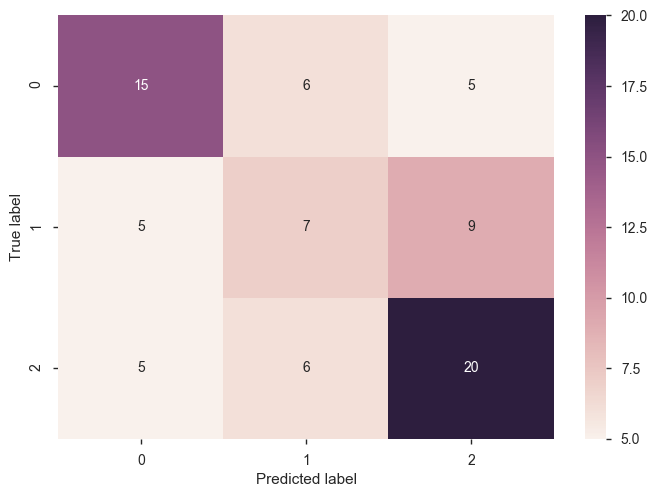

In [56]:
estimator = lgb.LGBMClassifier()
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03,0.04, 0.05],
    'num_leaves': [8, 10, 20, 30, 40, 50],
    'boosting_type' : ['gbdt'],
    'objective' : ['multiclass'],
    'metric': ['multi_logloss'],
    'num_class': [3],
    'seed' : [777],
    'colsample_bytree' : [0.6, 0.7,0.8,0.9,1],
    'subsample' : [0.6, 0.7,0.8,0.9,1],
    'reg_alpha' : [0,0.1,0.5,1],
    'reg_lambda' : [0,0.01, 0.05, 0.1, 1,2,5,6,7,9,10],
    'is_unbalance' : [True,False],
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_
y_pred = clf.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('Recall: {}'.format(cm[2][2]/sum(cm[2])))

[1]	valid_0's multi_logloss: 1.0965
[2]	valid_0's multi_logloss: 1.09463
[3]	valid_0's multi_logloss: 1.09401
[4]	valid_0's multi_logloss: 1.09297
[5]	valid_0's multi_logloss: 1.09213
[6]	valid_0's multi_logloss: 1.09102
[7]	valid_0's multi_logloss: 1.08936
[8]	valid_0's multi_logloss: 1.08731
[9]	valid_0's multi_logloss: 1.08563
[10]	valid_0's multi_logloss: 1.08481
[11]	valid_0's multi_logloss: 1.08437
[12]	valid_0's multi_logloss: 1.08284
[13]	valid_0's multi_logloss: 1.08206
[14]	valid_0's multi_logloss: 1.08102
[15]	valid_0's multi_logloss: 1.08015
[16]	valid_0's multi_logloss: 1.07925
[17]	valid_0's multi_logloss: 1.07805
[18]	valid_0's multi_logloss: 1.0766
[19]	valid_0's multi_logloss: 1.0759
[20]	valid_0's multi_logloss: 1.07525
[21]	valid_0's multi_logloss: 1.07397
[22]	valid_0's multi_logloss: 1.07281
[23]	valid_0's multi_logloss: 1.07177
[24]	valid_0's multi_logloss: 1.07097
[25]	valid_0's multi_logloss: 1.06949
[26]	valid_0's multi_logloss: 1.06832
[27]	valid_0's multi_log

Recall: 0.6774193548387096
Accuracy: 0.5512820512820513


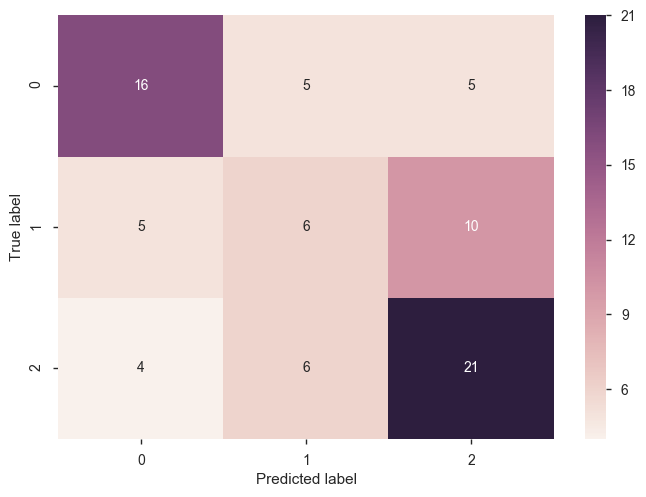

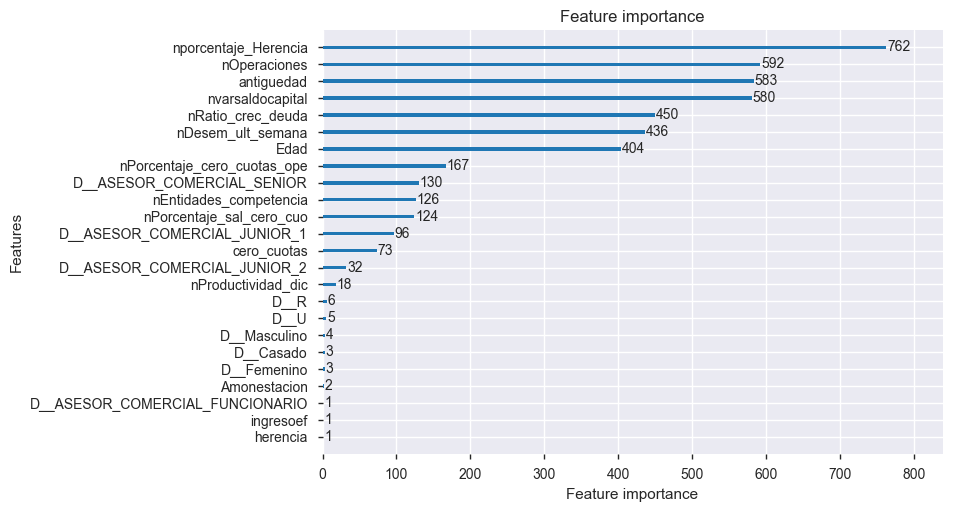

In [57]:
model = lgb.train(clf.best_params_, d_train, 100, valid_sets=d_valid)
y_pred = model.predict(X_valid)
y_pred_trunc = list()
for row in y_pred:
    y_pred_trunc.append(list(row).index(max(row)))
y_pred_trunc = pd.Series(y_pred_trunc)
cm = confusion_matrix(y_valid, y_pred_trunc)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Accuracy: {}'.format(accuracy_score(y_pred_trunc,y_valid)))
lgb.plot_importance(model)

In [38]:
d = dict(zip(model.feature_name(), model.feature_importance()))
sorted(d.items(), key=lambda x: x[1], reverse=True)

# Random Forest

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'max_depth': [5, 8, 15, 25, 30, None], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'max_depth': 8,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 120}

Recall: 0.6451612903225806


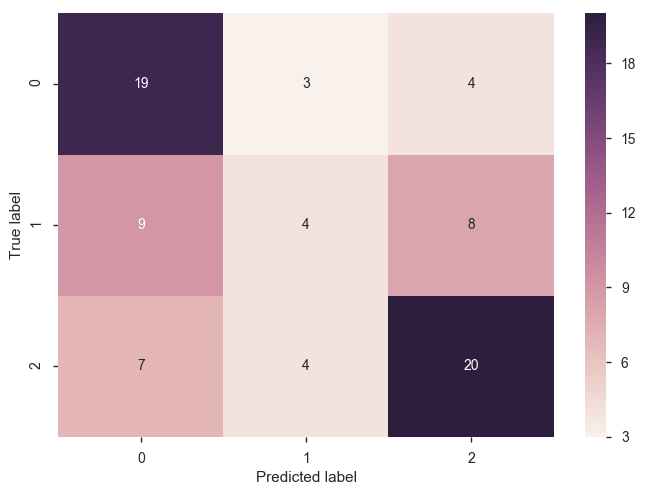

In [84]:
estimator = RandomForestClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'max_depth': [5, 8, 15, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_
y_pred = clf.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('Recall: {}'.format(cm[2][2]/sum(cm[2])))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False)

Recall: 0.6129032258064516
Accuracy: 0.5256410256410257


[('nOperaciones', 0.18228999604876958),
 ('nporcentaje_Herencia', 0.13553499515876199),
 ('antiguedad', 0.11136639557162024),
 ('nvarsaldocapital', 0.10221072741687219),
 ('nDesem_ult_semana', 0.07759725419998538),
 ('nRatio_crec_deuda', 0.064351074602779917),
 ('Edad', 0.05186716127397243),
 ('nPorcentaje_cero_cuotas_ope', 0.04345958667192322),
 ('nPorcentaje_sal_cero_cuo', 0.035186137936273877),
 ('nEntidades_competencia', 0.034498055447249432),
 ('D__ASESOR COMERCIAL SENIOR', 0.01968532059172835),
 ('D__ASESOR COMERCIAL JUNIOR 1', 0.018679338781545391),
 ('cero_cuotas', 0.01604813973871658),
 ('D__ASESOR COMERCIAL JUNIOR 2', 0.01368762216963023),
 ('nProductividad_dic', 0.010502356266560816),
 ('D__Masculino', 0.010406011838637649),
 ('D__Femenino', 0.0098870052589412737),
 ('ingresoef', 0.0095778736391572711),
 ('D__U', 0.0076617139037148336),
 ('nAmonestacion_suspension', 0.0075671512984154202),
 ('herencia', 0.0064315021008798743),
 ('D__Soltero', 0.0062164915738351289),
 ('D__R'

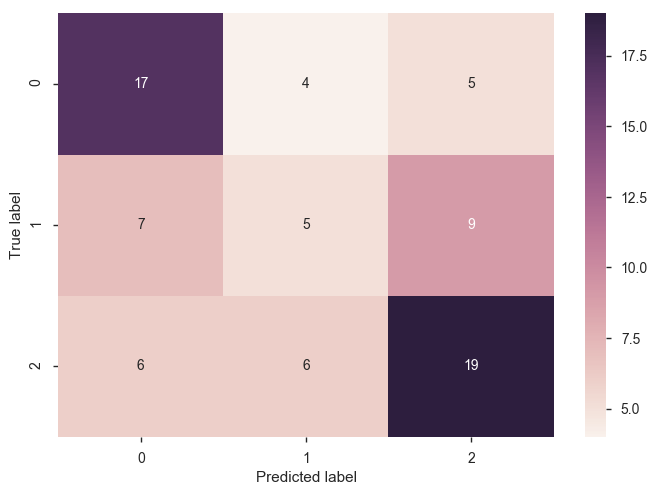

In [79]:
model = RandomForestClassifier(
    max_depth=clf.best_params_['max_depth'],
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))
d = dict(zip(list(X_train), model.feature_importances_))
sorted(d.items(), key=lambda x: x[1], reverse=True)

# Extra Trees

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 800}

Recall: 0.5806451612903226


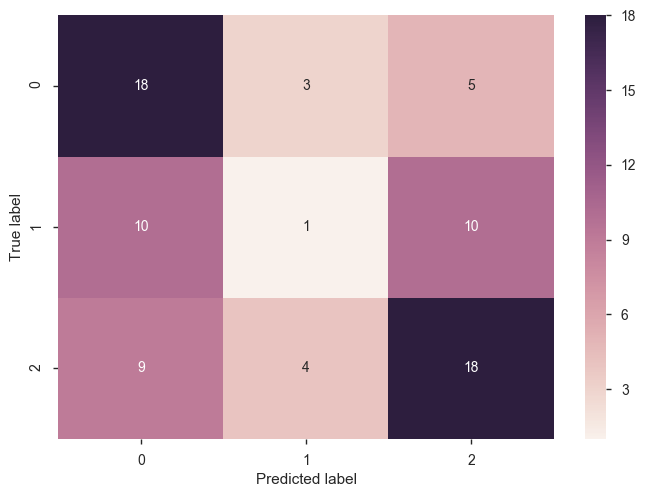

In [81]:
estimator = ExtraTreesClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_
y_pred = clf.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('Recall: {}'.format(cm[2][2]/sum(cm[2])))

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=800, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False)

Recall: 0.5806451612903226
Accuracy: 0.47435897435897434


[('nOperaciones', 0.18212254392230931),
 ('nporcentaje_Herencia', 0.085409755208196853),
 ('cero_cuotas', 0.067972508146308591),
 ('nProductividad_dic', 0.052596867890333375),
 ('antiguedad', 0.050040168882153235),
 ('D__ASESOR COMERCIAL SENIOR', 0.046076777694217114),
 ('herencia', 0.040125323996849732),
 ('nEntidades_competencia', 0.038102790146387629),
 ('nDesem_ult_semana', 0.033355700436435001),
 ('D__ASESOR COMERCIAL JUNIOR 1', 0.03237581797005902),
 ('D__ASESOR COMERCIAL JUNIOR 2', 0.03060137227350701),
 ('nAmonestacion_suspension', 0.029531729732787389),
 ('Edad', 0.029263082002585955),
 ('ingresoef', 0.029083018728198646),
 ('D__Femenino', 0.02808918150595123),
 ('D__Masculino', 0.027180759978100596),
 ('nvarsaldocapital', 0.025918898467692401),
 ('D__R', 0.022056541960149705),
 ('D__Soltero', 0.021716599184838745),
 ('nPorcentaje_cero_cuotas_ope', 0.021470690501279557),
 ('D__U', 0.021347624884356743),
 ('D__ASESOR COMERCIAL MASTER', 0.017961789478488213),
 ('D__Casado', 0.01

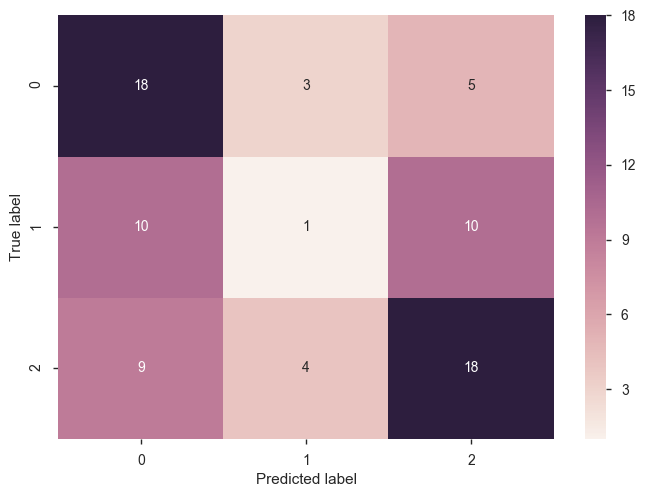

In [83]:
model = ExtraTreesClassifier(
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))
d = dict(zip(list(X_train), model.feature_importances_))
sorted(d.items(), key=lambda x: x[1], reverse=True)